# Cluster neighborhoods and embeddings

To further investigate the neuronal diversity within each major brain structure, [Yao et al](https://doi.org/10.1101/2023.03.06.531121) created concept of cell types "neighborhoods" or groups and use them for visualization and analysis. For each neighborhood, they genereated re-embedded UMAPS to reveal fine-grained relationships between neuronal types within and between brain regions.

In [1]:
import os
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import requests
import pathlib

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20230830'
download_base = '../../abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version
if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-neighborhoods']['directories']['metadata']['relative_path'], 
                              'views')
view_directory = pathlib.Path( view_directory )
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data Overview

### Cluster groups

Each cell type neighborhood is represented as a cluster group. Each row of the dataframe represnts a ***cluster group***. Each *cluster* has a *label* (human readable string that is unique in the database), *name*, *description* and the *number of clusters* that has been grouped together.

In [4]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
groups = pd.read_csv(file)
print("number of groups:",len(groups))
groups.set_index('label',inplace=True)
groups

number of groups: 8


,name,description,group_type,number_of_clusters
label,,,,
CCN20230722_HY-EA-Glut-GABA,HY-EA-Glut-GABA,Glutamatergic and GABAergic neurons in hypotha...,cell type neighborhood,1404
CCN20230722_MB-HB-CB-GABA,MB-HB-CB-GABA,"GABAergic neurons in midbrain, hindbrain, and ...",cell type neighborhood,1040
CCN20230722_MB-HB-Glut-Sero-Dopa,MB-HB-Glut-Sero-Dopa,"Glutamatergic, serotonergic and dopaminergic n...",cell type neighborhood,1431
CCN20230722_NN-IMN-GC,NN-IMN-GC,"Non-neuronal cells, immature neurons, granule ...",cell type neighborhood,248
CCN20230722_Pallium-Glut,Pallium-Glut,Glutamatergic neurons from cerebral cortex (de...,cell type neighborhood,517
CCN20230722_Subpallium-GABA,Subpallium-GABA,Telencephalic GABAergic neurons from cerebral ...,cell type neighborhood,1051
CCN20230722_TH-EPI-Glut,TH-EPI-Glut,Glutamatergic neurons from thalamus and epitha...,cell type neighborhood,148
CCN20230722_WholeBrain,WholeBrain,All cells in the whole mouse brain (5322 clust...,cell type neighborhood,5322


In [5]:
# print out description for each group
for tsindex, tsrow in groups.iterrows() :
    print("%s:\n" % tsrow['name'])
    print("%s\n" % tsrow['description'])

HY-EA-Glut-GABA:

Glutamatergic and GABAergic neurons in hypothalamus and extended amygdala, also including all non-pallium glutamatergic neurons in cerebral nuclei (1404 clusters)

MB-HB-CB-GABA:

GABAergic neurons in midbrain, hindbrain, and cerebellum (1040 clusters)

MB-HB-Glut-Sero-Dopa:

Glutamatergic, serotonergic and dopaminergic neurons in midbrain and hindbrain (1431 clusters)

NN-IMN-GC:

Non-neuronal cells, immature neurons, granule cells in dentate gyrus, olfactory bulb and cerebellum, and neurons in pineal gland (248 clusters)

Pallium-Glut:

Glutamatergic neurons from cerebral cortex (derived from the developmental pallium), including isocortex, hippocampal formation, olfactory areas, and cortical subplate (517 clusters)

Subpallium-GABA:

Telencephalic GABAergic neurons from cerebral cortex and cerebral nuclei, as well as some from the hypothalamic preoptic area, which are derived from the developmental subpallium (1051 clusters)

TH-EPI-Glut:

Glutamatergic neurons fro

### Cluster group membership

The association between a cluster and cluster group is represented as a cluster group membership.

In [6]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file)
group_membership.head(5)

,cluster_label,cluster_group_label,cluster_alias,cluster_group_name
0,CS20230722_0128,CCN20230722_Pallium-Glut,128,Pallium-Glut
1,CS20230722_0128,CCN20230722_WholeBrain,128,WholeBrain
2,CS20230722_0129,CCN20230722_Pallium-Glut,129,Pallium-Glut
3,CS20230722_0129,CCN20230722_WholeBrain,129,WholeBrain
4,CS20230722_0130,CCN20230722_Pallium-Glut,130,Pallium-Glut


### Dimension reductions

Principal component analysis (PCA) was first preformed on the gene expression matrix.
The top 100 PCs were selected and used to create a 2D UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) for all cells in the datasets. Further, for each neighborhood or cluster group, an additional specific 2D UMAP or embedding is created.

Each row of the ***dimension reduction*** dataframe represents on embedding. Each row of the dataframe represnts an embedding. Each *dimension reduction* has a *label* (human readable string that is unique in the database), *name*, *description*, the *number of cells* in the embedding and the label of the associated *cluster group*.

In [7]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['dimension_reduction']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
maps = pd.read_csv(file)
print("number of maps:",len(maps))
maps

number of maps: 8


,label,name,description,number_of_cells,cluster_group_label
0,UMAP20230830-HY-EA-Glut-GABA,HY-EA-Glut-GABA,Glutamatergic and GABAergic neurons in hypotha...,295448,CCN20230722_HY-EA-Glut-GABA
1,UMAP20230830-MB-HB-CB-GABA,MB-HB-CB-GABA,"GABAergic neurons in midbrain, hindbrain, and ...",186775,CCN20230722_MB-HB-CB-GABA
2,UMAP20230830-MB-HB-Glut-Sero-Dopa,MB-HB-Glut-Sero-Dopa,"Glutamatergic, serotonergic and dopaminergic n...",180669,CCN20230722_MB-HB-Glut-Sero-Dopa
3,UMAP20230830-NN-IMN-GC,NN-IMN-GC,"Non-neuronal cells, immature neurons, granule ...",1418529,CCN20230722_NN-IMN-GC
4,UMAP20230830-Pallium-Glut,Pallium-Glut,Glutamatergic neurons from cerebral cortex (de...,1494801,CCN20230722_Pallium-Glut
5,UMAP20230830-Subpallium-GABA,Subpallium-GABA,Telencephalic GABAergic neurons from cerebral ...,611423,CCN20230722_Subpallium-GABA
6,UMAP20230830-TH-EPI-Glut,TH-EPI-Glut,Glutamatergic neurons from thalamus and epitha...,126171,CCN20230722_TH-EPI-Glut
7,UMAP20230830-WholeBrain,WholeBrain,All cells in the whole mouse brain (5322 clust...,4042976,CCN20230722_WholeBrain


## Example use cases

### Cluster group membership pivot table

To support analysis and visualization by cluster group in later tutorials, we create a pivot table using pandas groupby fuunction. Each row of the resulting dataframe represents a cluster, each column represents cluster group and the value in the table is a boolean specifying if the cluster is a member of the cluster group.

In [8]:
pivot = group_membership.groupby(['cluster_alias','cluster_group_name'])['cluster_group_name'].first().unstack()
pivot = pivot.notna()
pivot

cluster_group_name,HY-EA-Glut-GABA,MB-HB-CB-GABA,MB-HB-Glut-Sero-Dopa,NN-IMN-GC,Pallium-Glut,Subpallium-GABA,TH-EPI-Glut,WholeBrain
cluster_alias,,,,,,,,
1,False,False,False,False,True,False,False,True
2,False,False,False,False,True,False,False,True
3,False,False,False,False,True,False,False,True
4,False,False,False,False,True,False,False,True
5,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...
34368,False,True,False,False,False,False,False,True
34372,False,True,False,False,False,False,False,True
34374,False,True,False,False,False,False,False,True


For convenience, we can cache this view for later reuse.

In [9]:
if cache_views :
    
    file = os.path.join( view_directory, 'cluster_group_membership_pivoted.csv')
    pivot.to_csv( file )

### Visualize a cluster group in whole brain and neighborhood embeddings

In this example, we visualize cluster group "CCN20230722_HY-EA-Glut-GABA" in context the whole brain UMAP and specific "HY-EA-Glut-GABA" UMAP.

First step is to read in 10x cell metadata with annotation dataframe.

In [10]:
metadata = manifest['file_listing']['WMB-10X']['metadata']
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"neurotransmitter":str})
cell.set_index('cell_label',inplace=True)

We join with cluster membership pivot table to get cell to cluster group member. For convenience, we can cache this view for later reuse.

In [11]:
joined_10x = cell.join(pivot,on='cluster_alias')

if cache_views :
    
    file = os.path.join( view_directory, '10x_cell_metadata_with_group_membership.csv')
    joined_10x.to_csv( file )

We defined a helper function to plot a UMAP using matplotlib scatter function.

In [12]:
def plot_umap( xx, yy, cc=None, val=None, fig_width = 8, fig_height = 8, cmap=None ) :
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx,yy,s=0.5,c=val,marker='.',cmap=cmap)
    elif cc is not None :
        plt.scatter(xx,yy,s=0.5,color=cc,marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18,27)
    ax.set_ylim(-18,27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

First we plot all cells in the whole brain UMAP colorized by cell type classes

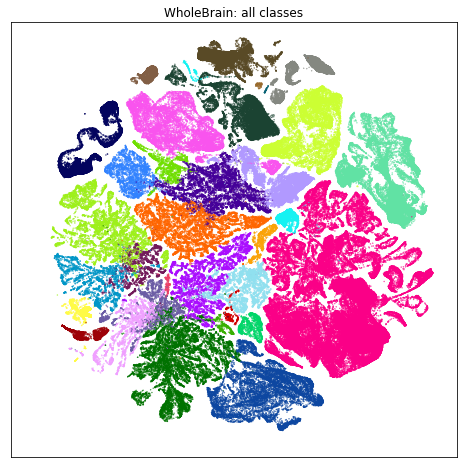

In [13]:
subsampled = joined_10x.loc[::10]
color = subsampled['class_color'].copy()
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: all classes')

We filter to only colorized cells in the "HY-EA-Glut-GABA" cluster group to visualize cell type classes, subclasses and neurotransmitter types

Glutamatergic and GABAergic neurons in hypothalamus and extended amygdala, also including all non-pallium glutamatergic neurons in cerebral nuclei (1404 clusters)


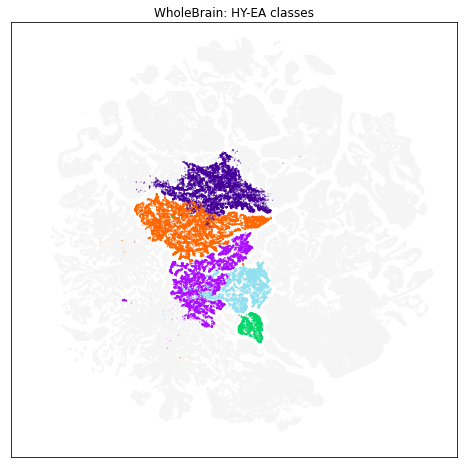

In [14]:
glabel = "CCN20230722_HY-EA-Glut-GABA"
print(groups.loc[glabel,'description'])
gname = groups.loc[glabel,'name']
pred = (subsampled[gname] == False)

color = subsampled['class_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA classes')

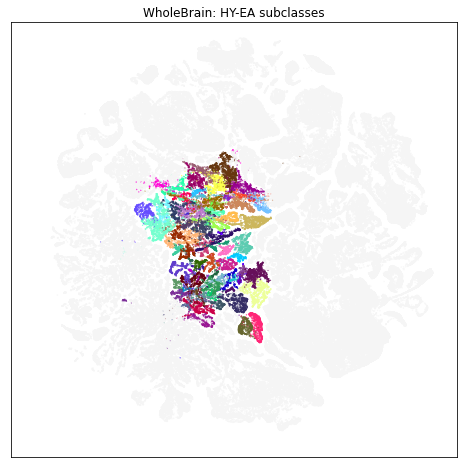

In [15]:
color = subsampled['subclass_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA subclasses')

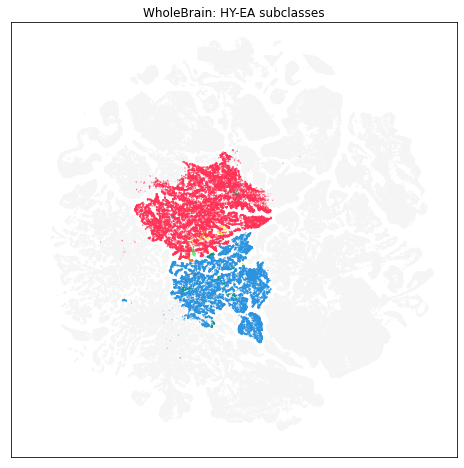

In [16]:
color = subsampled['neurotransmitter_color'].copy()
color[pred] = '#f5f5f5'
fig, ax = plot_umap(subsampled['x'], subsampled['y'],cc=color)
res = ax.set_title('WholeBrain: HY-EA subclasses')

In this next section, we read in the coordinates for the HY-EA-Glut-GABA specific embedding

In [17]:
maps_by_group = maps.set_index('cluster_group_label')
mlabel = maps_by_group.loc[glabel,'label']

metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata[mlabel]['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
coord = pd.read_csv(file)
coord.set_index('cell_label',inplace=True)

We create a new dataframe "neighborhoos" by joining the spatial coordinates with cell metadata

In [18]:
neighborhood = coord.join( joined_10x, how='left', rsuffix='orig')

We can resuse the same plot umap helper function to visualize cell type classes, subclasses and neurotransmitter types in the new embedding

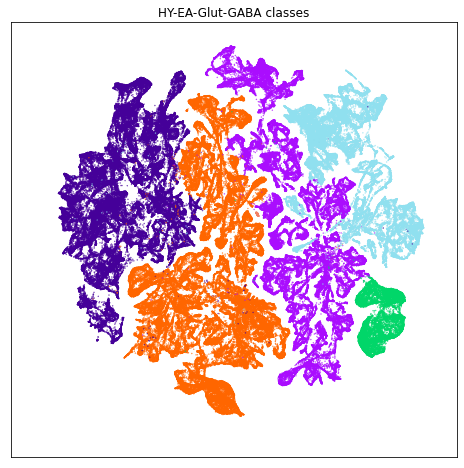

In [19]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['class_color'])
res = ax.set_title('HY-EA-Glut-GABA classes')

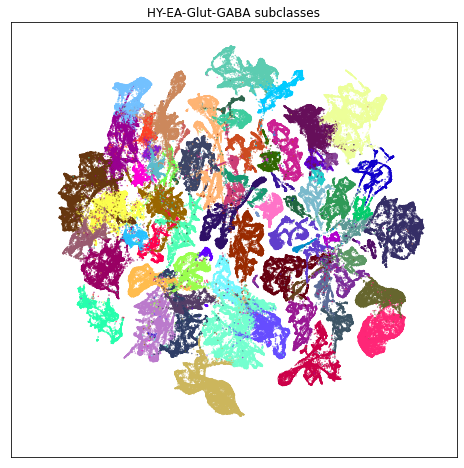

In [20]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['subclass_color'])
res = ax.set_title('HY-EA-Glut-GABA subclasses')

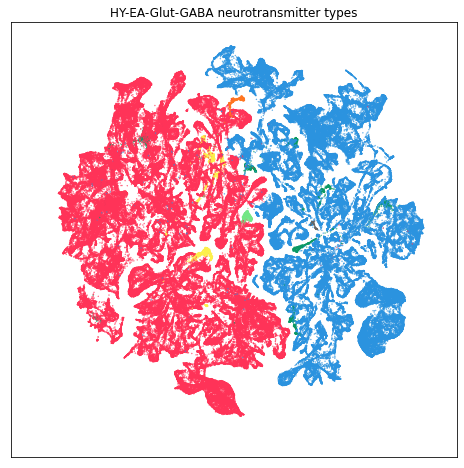

In [21]:
fig, ax = plot_umap(neighborhood['x'], neighborhood['y'],cc=neighborhood['neurotransmitter_color'])
res = ax.set_title('HY-EA-Glut-GABA neurotransmitter types')

### Visualize gene expression in neighborhood embedings

In this section, we show how to visualize gene expression in a neighborhood specific embedding. We start by reading in the gene expression dataframe we previously cached in the metadata directory from running 10x part 2a tutorial.

In [22]:
metadata = manifest['file_listing']['WMB-10X']['metadata']
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
print(exp.columns)

Index(['Slc32a1', 'Slc17a7', 'Slc6a5', 'Slc17a6', 'Slc6a2', 'Slc17a8', 'Tac2',
       'Slc6a4', 'Slc6a3', 'Slc18a3'],
      dtype='object')


We create a new dataframe "neighborhood_exp" that joins the neighborhood with gene expression information. We resuse the plot umap helper function to plot expression for genes Slc32a1 (GABAergic enriched) and Slc17ab (Glutamergic enriched).

In [23]:
neighborhood_exp = neighborhood.join(exp)

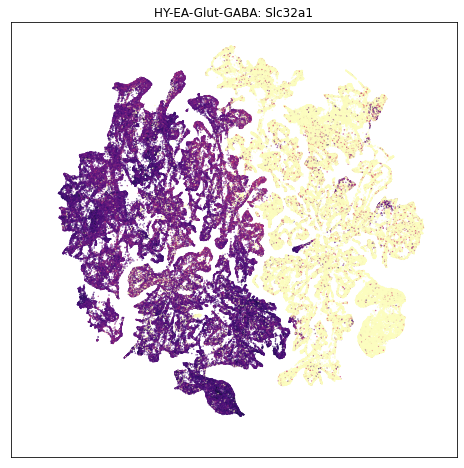

In [24]:
gene = 'Slc32a1'
fig, ax = plot_umap(neighborhood_exp['x'], neighborhood_exp['y'],val=neighborhood_exp[gene],cmap=plt.cm.magma_r)
res = ax.set_title('HY-EA-Glut-GABA: %s' % gene )

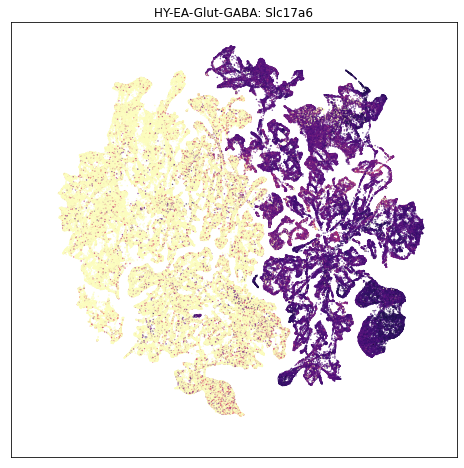

In [25]:
gene = 'Slc17a6'
fig, ax = plot_umap(neighborhood_exp['x'], neighborhood_exp['y'],val=neighborhood_exp[gene],cmap=plt.cm.magma_r)
res = ax.set_title('HY-EA-Glut-GABA: %s' % gene )

### Visualize cluster groups in anatomical context

In this section, we visualize a cluster group in anatomical context using the whole brain merfish dataset. We begin by reading in the extended cell metadata dataframe.

In [26]:
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cell = pd.read_csv(file,dtype={"cell_label":str})
cell.set_index('cell_label',inplace=True)

We join with cluster membership pivot table to get cell to cluster group member. For convenience, we can cache this view for later reuse.

In [27]:
joined_merfish = cell.join(pivot,on='cluster_alias')

if cache_views :
    
    file = os.path.join( view_directory, 'merfish_cell_metadata_with_group_membership.csv')
    joined_merfish.to_csv( file )

We create a helper function to visualized a set of brain sections, colorized by specified cell property and filtered to a user specified cluster group.

In [28]:
def plot_sections( df, group, feature, blist, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']

        vv = filtered[feature].copy()
        pred = (filtered[group] == False)
        vv[pred] = '#f5f5f5'
        
        ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s: %s" % (group,bsl) )
        
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()
    return fig, ax

We use the helper function to view 6 MERFISH sections, colorized by cell type subclass and restricted to HY-EA-Glut-GABA subgroup.

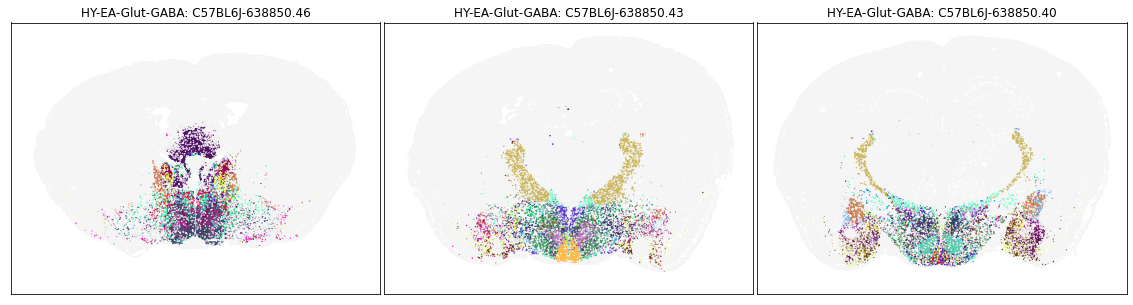

In [29]:
blist = ['C57BL6J-638850.46','C57BL6J-638850.43','C57BL6J-638850.40']
fig, ax = plot_sections( joined_merfish, 'HY-EA-Glut-GABA', 'subclass_color', blist )

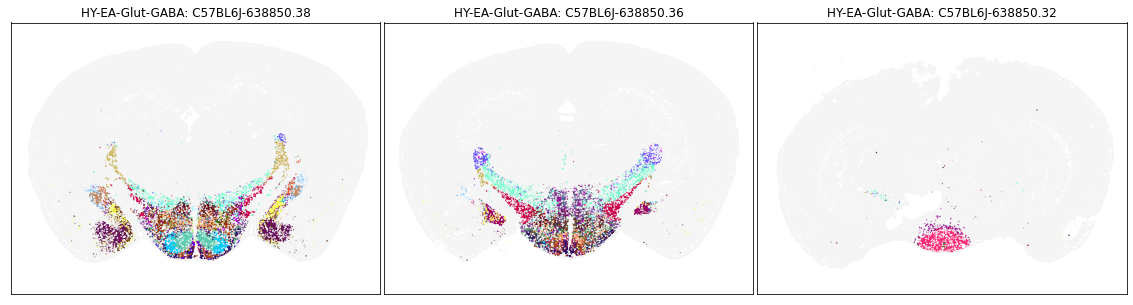

In [30]:
blist = ['C57BL6J-638850.38','C57BL6J-638850.36','C57BL6J-638850.32']
fig, ax = plot_sections( joined_merfish, 'HY-EA-Glut-GABA', 'subclass_color', blist )